<a href="https://colab.research.google.com/github/lox228-lox/-/blob/main/Sirius.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Очищение датасета(обработка отсутствующих значений, обнаружение аномалий и выбросов)

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import sys

# Загрузка датасета из CSV файла
dataset = pd.read_csv('/content/drive/MyDrive/train.csv')

# Проверка наличия пропущенных значений и удаление столбцов с слишком многими пропусками
missing_values_counts = dataset.isnull().sum()
threshold = len(dataset) * 0.4
columns_to_drop = missing_values_counts[missing_values_counts > threshold].index
dataset.drop(columns=columns_to_drop, inplace=True)

# Если остались пропущенные значения, заполняем их средними значениями
dataset.fillna(dataset.mean(), inplace=True)

# Обработка аномалий и выбросов
def clean_dataset(df):
    # Удаление отсутствующих значений
    df.dropna(inplace=True)

    # Удаление выбросов для числовых данных
    numeric_columns = df.select_dtypes(include=['number']).columns
    numeric_columns = [col for col in numeric_columns if col != "id"]  # Исключаем столбец "id"
    for col in numeric_columns:
        mean = df[col].mean()
        std = df[col].std()
        df = df[~((df[col] < (mean - 3 * std)) | (df[col] > (mean + 3 * std)))]

    return df

cleaned_dataset = clean_dataset(dataset)
# Сохранение очищенного датасета в новом файле
cleaned_dataset.to_csv('/content/drive/MyDrive/clear 2.csv', index=False)

cleaned_dataset_encoded = pd.get_dummies(cleaned_dataset)

<ipython-input-41-2b0db723ef87>:25: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.fillna(dataset.mean(), inplace=True)


Обработка лишних значений

In [42]:
cleaned_dataset_encoded = cleaned_dataset_encoded.drop(columns=["id"])

# Проверка на наличие пропусков
missing_values = cleaned_dataset_encoded.isnull().sum()

if missing_values.sum() > 0:
    print("**В датасете есть пропуски!**")
    print("**Рекомендуется обработать пропуски перед дальнейшим анализом.**")
    sys.exit()

# Вычисление корреляционной матрицы
corr_matrix = cleaned_dataset_encoded.corr()

# Вывод топ 5 пар с самой высокой корреляцией
print("Топ 5 пар с самой высокой корреляцией:")
print(corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:5])

# Вывод топ 5 пар с самой низкой корреляцией
print("\nТоп 5 пар с самой низкой корреляцией:")
print(corr_matrix.unstack().sort_values().drop_duplicates()[:5])

Топ 5 пар с самой высокой корреляцией:
public_transport_station_km    public_transport_station_min_walk    1.0
sub_area_Poselenie Vnukovskoe  build_count_mix                      1.0
full_sq                        full_sq                              1.0
build_count_foam               build_count_mix                      1.0
metro_min_walk                 metro_km_walk                        1.0
dtype: float64

Топ 5 пар с самой низкой корреляцией:
detention_facility_raion_yes  detention_facility_raion_no   -1.0
radiation_raion_yes           radiation_raion_no            -1.0
incineration_raion_no         sub_area_Nekrasovka           -1.0
big_road1_1line_yes           big_road1_1line_no            -1.0
water_1line_yes               water_1line_no                -1.0
dtype: float64


Проверка сбалансированости

In [44]:
# Разделение на признаки и целевую переменную
X = cleaned_dataset_encoded.drop(columns=['price_doc'])
y = cleaned_dataset_encoded['price_doc']

# Вычисление распределения классов
class_counts = Counter(y)
print("Исходное распределение классов:", class_counts)

# Проверка на дисбаланс классов
majority_class_count = max(class_counts.values())
minority_class_count = min(class_counts.values())
class_ratio = majority_class_count / minority_class_count

if class_ratio > 2:  # Порог для определения дисбаланса
    # Применение upsampling
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X, y)
    # Вычисление распределения классов после upsampling
    resampled_class_counts = Counter(y_resampled)
    print("Новое распределение классов после upsampling:", resampled_class_counts)

else:
    print("Датасет сбалансирован, не требуется upsampling.")

Исходное распределение классов: Counter({4400000: 39, 6592000: 25, 1000000: 23, 4462000: 22, 5903808: 20, 4740002: 19, 3274574: 17, 6000000: 16, 6300000: 16, 2000000: 16, 7682400: 16, 4138020: 16, 6200000: 15, 5800000: 14, 4061390: 14, 6400000: 13, 5115198: 13, 6530200: 13, 5500000: 12, 7400000: 12, 6272000: 12, 8000000: 11, 5174562: 11, 5313000: 11, 5300000: 10, 5073100: 10, 8500000: 10, 6518400: 10, 7221456: 10, 4700000: 9, 6500000: 9, 5700000: 9, 3000000: 9, 6600000: 9, 7000000: 9, 5900000: 9, 5335000: 9, 5000000: 8, 4900000: 8, 7900000: 8, 3984760: 8, 5764128: 8, 4328140: 8, 5959680: 8, 4214650: 8, 6344800: 8, 5850000: 7, 6700000: 7, 7200000: 7, 3958570: 7, 4768714: 7, 4750284: 7, 6750000: 7, 7528752: 7, 4740000: 7, 4640000: 7, 4800000: 6, 8900000: 6, 7800000: 6, 6900000: 6, 8300000: 6, 9500000: 6, 4000000: 6, 6100000: 6, 5782752: 6, 4064688: 6, 7536900: 6, 6528000: 6, 3940000: 6, 6552000: 6, 990000: 5, 9000000: 5, 6650000: 5, 7300000: 5, 5400000: 5, 7700000: 5, 8200000: 5, 5014900

Визуализация влияния на целевую переменную(линейная регрессия)

Только несколько максимальных и минимальных значений:
                  Признак      Важность
5                num_room  4.467678e-01
0                 full_sq  2.444570e-01
138           trc_sqm_500  2.943450e-02
128             mosque_km  2.496103e-02
132           catering_km  2.166000e-02
462  timestamp_2013-03-20 -4.250796e-21
9         green_zone_part  0.000000e+00
10            indust_part  0.000000e+00
11     children_preschool  0.000000e+00
12        preschool_quota  0.000000e+00


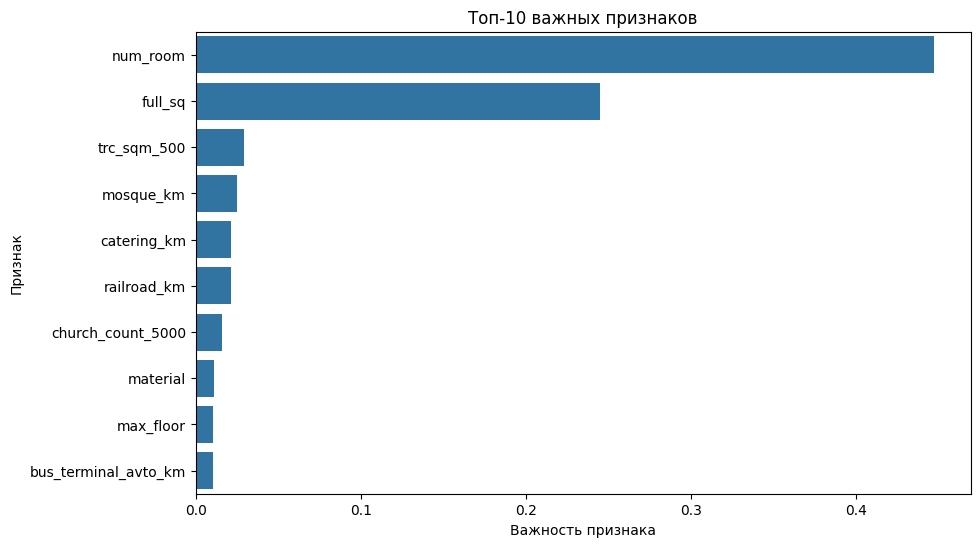

Среднеквадратичная ошибка (MSE): 620971728334.9725
Средняя абсолютная ошибка (MAE): 483279.08700565173
Коэффициент детерминации (R^2): 0.7737181388833236


In [46]:
# Разделение на признаки и целевую переменную
X = cleaned_dataset_encoded.drop(columns=['price_doc'])
y = cleaned_dataset_encoded['price_doc']

# Разделение данных на обучающий и тестовый наборы после преобразования данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели линейной регрессии на увеличенных данных, если датасет был несбалансированным
if class_ratio > 2:
    model = GradientBoostingRegressor()
    model.fit(X_resampled, y_resampled)
else:
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

# Вывод коэффициентов модели
feature_importance = model.feature_importances_
coefficients = pd.DataFrame({'Признак': X.columns, 'Важность': feature_importance})
coefficients_sorted = coefficients.sort_values(by='Важность', ascending=False)

# Важность признаков
feature_importance = pd.DataFrame({'Признак': X.columns, 'Важность': model.feature_importances_})

# Сортировка по важности и выбор только нескольких максимальных и минимальных значений
top_n = 5  # количество максимальных и минимальных значений для отображения
top_features = feature_importance.nlargest(top_n, 'Важность')
bottom_features = feature_importance.nsmallest(top_n, 'Важность')

# Объединение важных и неважных признаков
selected_features = pd.concat([top_features, bottom_features])

print("Только несколько максимальных и минимальных значений:")
print(selected_features)


# Отображение важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=coefficients_sorted.head(10))
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Топ-10 важных признаков')
plt.show()

# Предсказанные значения модели
predictions = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Коэффициент детерминации (R^2):", r2)

Визуализация влияния на целевую переменную(решающие деревья)

Только несколько максимальных и минимальных значений:
                                   Признак  Важность
5                                 num_room  0.520921
0                                  full_sq  0.105649
138                            trc_sqm_500  0.080704
263                      church_count_5000  0.023970
99                             railroad_km  0.023006
8                              raion_popul  0.000000
14                         children_school  0.000000
15                            school_quota  0.000000
17   school_education_centers_top_20_raion  0.000000
19                 university_top_20_raion  0.000000


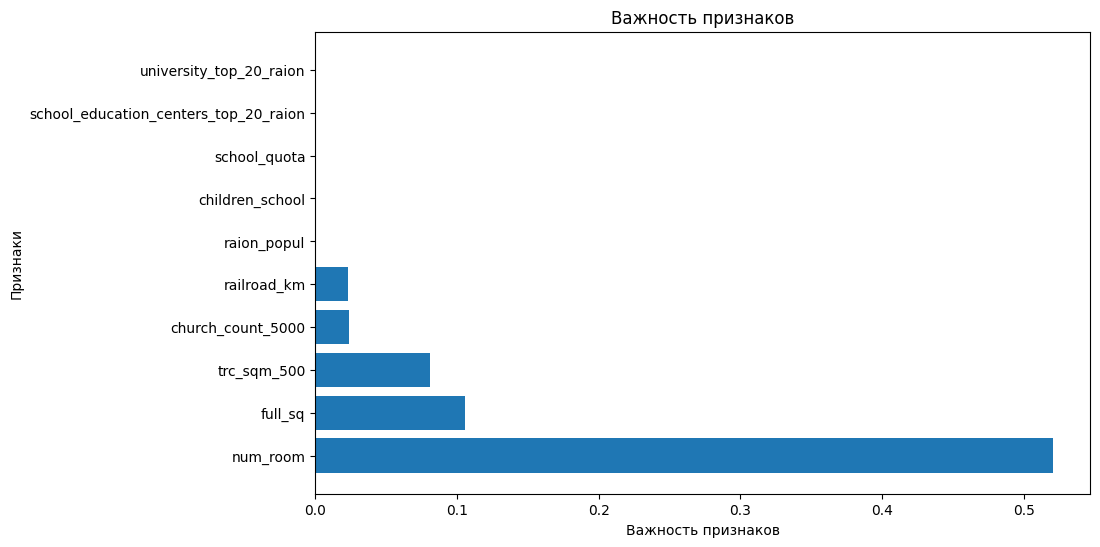

Среднеквадратичная ошибка (MSE): 47015691.58949115
Средняя абсолютная ошибка (MAE): 288.46769911504424
Коэффициент детерминации (R^2): 0.9999828674999052


In [38]:
# Обучение модели линейной регрессии на увеличенных данных, если датасет был несбалансированным
if class_ratio > 2:
    model = DecisionTreeRegressor()
    model.fit(X_resampled, y_resampled)
else:
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)

# Вывод коэффициентов модели
feature_importance = model.feature_importances_
coefficients = pd.DataFrame({'Признак': X.columns, 'Коэффициент': feature_importance})
coefficients_sorted = coefficients.sort_values(by='Коэффициент', ascending=False)

# Важность признаков
feature_importance = pd.DataFrame({'Признак': X.columns, 'Важность': model.feature_importances_})

# Сортировка по важности и выбор только нескольких максимальных и минимальных значений
top_n = 5  # количество максимальных и минимальных значений для отображения
top_features = feature_importance.nlargest(top_n, 'Важность')
bottom_features = feature_importance.nsmallest(top_n, 'Важность')

# Объединение важных и неважных признаков
selected_features = pd.concat([top_features, bottom_features])

print("Только несколько максимальных и минимальных значений:")
print(selected_features)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(selected_features['Признак'], selected_features['Важность'])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

# Предсказанные значения модели
predictions = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Коэффициент детерминации (R^2):", r2)

Визуализация влияния на целевую переменную(градиентный бустинг)

                Признак  Коэффициент
0              num_room     0.446796
1               full_sq     0.244465
2           trc_sqm_500     0.029428
3             mosque_km     0.025078
4           catering_km     0.021646
5  timestamp_2013-03-25     0.000000
6  timestamp_2013-03-26     0.000000
7  timestamp_2013-03-27     0.000000
8  timestamp_2013-03-28     0.000000
9  timestamp_2013-08-14     0.000000


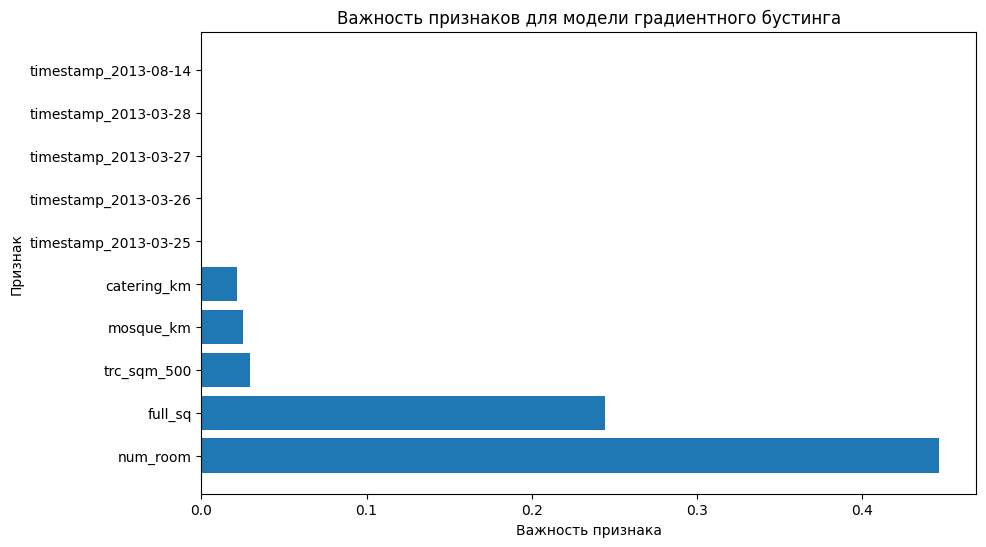

Среднеквадратичная ошибка (MSE): 620971728334.9746
Средняя абсолютная ошибка (MAE): 483279.08700565196
Коэффициент детерминации (R^2): 0.773718138883323


In [39]:
# Обучение модели линейной регрессии на увеличенных данных, если датасет был несбалансированным
if class_ratio > 2:
    model = GradientBoostingRegressor()
    model.fit(X_resampled, y_resampled)
else:
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

# Вывод коэффициентов модели
feature_importance = model.feature_importances_
coefficients = pd.DataFrame({'Признак': X.columns, 'Коэффициент': feature_importance})
coefficients_sorted = coefficients.sort_values(by='Коэффициент', ascending=False)

# Отображение нескольких максимальных и минимальных значений
top_n = 5
top_features = pd.concat([coefficients_sorted.head(top_n), coefficients_sorted.tail(top_n)])
top_features.reset_index(drop=True, inplace=True)
print(top_features)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_features['Признак'], top_features['Коэффициент'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков для модели градиентного бустинга')
plt.show()

# Предсказанные значения модели
predictions = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Среднеквадратичная ошибка (MSE):", mse)
print("Средняя абсолютная ошибка (MAE):", mae)
print("Коэффициент детерминации (R^2):", r2)